In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import pickle
import glob

import fair_ct

import cvxpy as cp

In [11]:
# The notebook demonstrates the workflow of learning fair interfentions.
# The steps are as following:
#  1. Learn a bunch of causal trees using bootstrap, with appropriate hyperparameters, save the trees
#  2. For a set of constraints, run optimization on all the saved trees, find the averaged assiment of treatment
#  3. Optional: Results visualization

# This notebook takes around 40 min to run.

In [2]:
df = pd.read_csv("./edgap_clean_sel.csv")

In [3]:
features = [\
       'member', 'num_magnet_schools', 'num_charter_schools',\
       'TOTFRL', 'FRELCH',\
       'pct_participating', 'popu_tot',\
       'meanic_hh', 'hh_ratio_married', 'hh_ratio_female', 'highschool',\
       'bachelorplus', 'employ', 'gini']

In [4]:
def get_data_split(df, method, verbos=False):
    n = df.shape[0]
    if(verbos):
        print("n = ", n)
    
    assert(method in ["honest", "honest_valid"])
    
    if(method == "honest"):
        n_train = n//3
        n_valid = n//3
        n_est = n-n_train-n_valid
        if(verbos):
            print("n_train = ", n_train)
            print("n_valid = ", n_valid)
            print("n_est = ", n_est)

        df = df.sample(frac=1)
        data_train = df.head(n_train)
        data_valid = df.head(n_train+n_valid).tail(n_valid)
        data_est = df.tail(n_est)
    elif(method == "honest_valid"):
        n_train = n//2
        n_valid = n - n_train
        n_est = n_valid
        if(verbos):
            print("n_train = ", n_train)
            print("n_valid = ", n_valid)
            print("n_est = ", n_est)

        df = df.sample(frac=1)
        data_train = df.head(n_train)
        data_valid = df.tail(n_valid)
        data_est = df.tail(n_valid)
    
    return data_train, data_valid, data_est

### Generate bootstrap causal trees and store locally

In [5]:
n_run = 40
os.system("rm -rf ./model_save; mkdir ./model_save")
os.system("mkdir ./model_save/plot; mkdir ./model_save/model; mkdir model_save/leaf")
for i_run in range(n_run):
    
    data_train, data_valid, data_est = get_data_split(df, "honest")

    X_train = data_train[features].values
    y_train = data_train["y"].values
    t_train = data_train["t_median"].values

    X_valid = data_valid[features].values
    y_valid = data_valid["y"].values
    t_valid = data_valid["t_median"].values

    X_est = data_est[features].values
    y_est = data_est["y"].values
    t_est = data_est["t_median"].values
    z_est = data_est["z_median"].values
    
    ## make sure you tune the hyperparameters!
    model = fair_ct.fair_ct(max_depth = 10, min_samples_leaf=70)
    model.fit(
        X_train, y_train, t_train,\
        X_est, y_est, t_est)
    
    #model.traversal()
    
    leaf_node_info = model.get_leaf_node_info(X_est, y_est, t_est, z_est)
    #print(leaf_node_info)
    
    model.show_tree("./model_save/plot/tree_%04d.pdf"%(i_run), features, ifshowz=False)
    pickle.dump(model, open("./model_save/model/model_%04d.bin"%(i_run), "wb"))
    pickle.dump(leaf_node_info, open("./model_save/leaf/leaf_%04d.bin"%(i_run), "wb"))

### load the generated trees and perform optimization

In [6]:
def load_leaf_info(path):
    leaf_node_info = pickle.load(open(path, "rb"))
    
    ## find all the values of z
    z_vals = set([])
    for node in leaf_node_info:
        z_node = node['effect_z_list'].keys()
        z_vals = z_vals.union(set(z_node))
    
    ## allocate space for data extract
    n_leaf = len(leaf_node_info)
    z_n = np.zeros((n_leaf, len(z_vals)))
    z_n1 = np.zeros((n_leaf, len(z_vals)))
    z_y1 = np.zeros((n_leaf, len(z_vals)))
    z_y0 = np.zeros((n_leaf, len(z_vals)))
    leaf_n = np.zeros((n_leaf))
    leaf_n1 = np.zeros((n_leaf))
    leaf_y1 = np.zeros((n_leaf))
    leaf_y0 = np.zeros((n_leaf))
    index = []
    
    ## extract data
    for i in range(len(leaf_node_info)):
        index.append(leaf_node_info[i]["index"])
        
        leaf_n[i] = leaf_node_info[i]["effect"][2][0] + leaf_node_info[i]["effect"][2][1]
        leaf_n1[i] = leaf_node_info[i]["effect"][2][1]
        leaf_y1[i] = leaf_node_info[i]["effect"][0][2]
        leaf_y0[i] = leaf_node_info[i]["effect"][0][1]
        for j in range(len(z_vals)):
            if(j in leaf_node_info[i]["effect_z_list"]):   
                z_n[i][j] = leaf_node_info[i]["effect_z_list"][j][2][0] + leaf_node_info[i]["effect_z_list"][j][2][1]
                z_n1[i][j] = leaf_node_info[i]["effect_z_list"][j][2][1]
                z_y1[i][j] = leaf_node_info[i]["effect_z_list"][j][0][2]
                z_y0[i][j] = leaf_node_info[i]["effect_z_list"][j][0][1]
            else:
                z_n[i][j] = 0
                z_n1[i][j] = 0
                z_y1[i][j] = 0
                z_y0[i][j] = 0
    res = {}
    res["index"]= index
    res["leaf_n"] = leaf_n; res["z_n"] = z_n
    res["leaf_y0"] = leaf_y0; res["leaf_y1"] = leaf_y1
    res["z_y0"] = z_y0; res["z_y1"] = z_y1
    
    res["z_n1"] = z_n1 ## added 2021-09-03 by yuzi he.
    return res

In [7]:
def find_opt_policy(leaf_n, z_n, leaf_y0, leaf_y1, z_y0, z_y1, obj_s, treat_limit, bias_limit):
    x = cp.Variable(len(leaf_n))
    y_bar = 1./np.sum(leaf_n)*(x.T@(leaf_n*leaf_y1) + (1.-x).T@(leaf_n*leaf_y0))
    if(obj_s == "max"): objective = cp.Maximize(y_bar)
    elif(obj_s == "min"): objective = cp.Minimize(y_bar)
    else:
        raise("Unknown obj_s. obj_s must be max or min!")
        
        
    ## constrains
    constraints = []
    constraints+=[x>=0, x<=1] ## constrant 1
    constraints+=[x.T@leaf_n<=treat_limit*np.sum(leaf_n)] ## constraint 2
    
    z_dim = z_n.shape[1]
    q = (z_n.T/leaf_n).T
    #print("z_dim = ", z_dim)
        
    for j1 in range(z_dim):
        for j2 in range(j1+1, z_dim):
            #print("j1 = ", j1, "j2 = ", j2)
            ## avg_j1 = 1./np.sum(leaf_n*q[:,j1])*(x.T@(leaf_n*q[:,j1]*z_y1[:,j1]) + (1.-x).T@(leaf_n*q[:,j1]*z_y0[:,j1]))
            ## avg_j2 = 1./np.sum(leaf_n*q[:,j2])*(x.T@(leaf_n*q[:,j2]*z_y1[:,j2]) + (1.-x).T@(leaf_n*q[:,j2]*z_y0[:,j2]))
            avg_j1 = 1./np.sum(z_n[:,j1])*(x.T@(z_n[:,j1]*z_y1[:,j1]) + (1.-x).T@(z_n[:,j1]*z_y0[:,j1]))
            avg_j2 = 1./np.sum(z_n[:,j2])*(x.T@(z_n[:,j2]*z_y1[:,j2]) + (1.-x).T@(z_n[:,j2]*z_y0[:,j2]))
            constraints += [avg_j1-avg_j2<=bias_limit, avg_j1-avg_j2>=-bias_limit]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(qcp=True)
    
    return {"obj":result, "r":x.value}

def find_opt_policy_affirmative(leaf_n, z_n, leaf_y0, leaf_y1, z_y0, z_y1, obj_s, treat_limit, bias_limit, oppo_limit):
    x = cp.Variable(z_n.shape)
    y_bar = 1./np.sum(leaf_n)* cp.sum(cp.multiply(z_n*z_y1, x) + cp.multiply(z_n*z_y0, 1.-x))
    if(obj_s == "max"): objective = cp.Maximize(y_bar)
    elif(obj_s == "min"): objective = cp.Minimize(y_bar)
    else:
        raise("Unknown obj_s. obj_s must be max or min!")
    
    ## base line, no one is treated
    y_baseline = np.sum(leaf_n*leaf_y0)/np.sum(leaf_n)
    
    ## constrains
    constraints = []
    constraints+=[x>=0, x<=1] ## constrant 1
    constraints+=[cp.sum(cp.multiply(z_n, x))<=treat_limit*np.sum(leaf_n)] ## constraint 2
    
    ## constrains on bias y
    z_dim = z_n.shape[1]
    for j1 in range(z_dim):
        for j2 in range(j1+1, z_dim):
            avg_j1 = 1./np.sum(z_n[:, j1])*(x[:,j1].T@(z_n[:,j1]*z_y1[:,j1]) + (1.-x[:,j1]).T@(z_n[:,j1]*z_y0[:,j1]))
            avg_j2 = 1./np.sum(z_n[:, j2])*(x[:,j2].T@(z_n[:,j2]*z_y1[:,j2]) + (1.-x[:,j2]).T@(z_n[:,j2]*z_y0[:,j2]))
            constraints += [avg_j1-avg_j2<=bias_limit, avg_j1-avg_j2>=-bias_limit]
    
    ## removed, worst case constrain for treatment oppo
    if(False):
        for j1 in range(z_dim):
            for j2 in range(j1+1, z_dim):
                constraints += [x[:,j1]-x[:,j2]<=oppo_limit, x[:,j1]-x[:,j2]>=-oppo_limit]
                
    ## replacement, avg constrain for treatment oppo
    if(True):
        for j1 in range(z_dim):
            for j2 in range(j1+1, z_dim):
                avg_oppo_j1 = 1./np.sum(z_n[:,j1])*(x[:,j1].T@z_n[:,j1])
                avg_oppo_j2 = 1./np.sum(z_n[:,j2])*(x[:,j2].T@z_n[:,j2])
                constraints += [avg_oppo_j1-avg_oppo_j2<=oppo_limit, avg_oppo_j1-avg_oppo_j2>=-oppo_limit]
                #print("add constrain avg oppo")
    
    prob = cp.Problem(objective, constraints)
    result = prob.solve(qcp=True)
    
    return {"obj":result, "r":x.value, "baseline":y_baseline}    

In [8]:
## first load all the leaf node infos
leaf_path_list = sorted(glob.glob("./model_save/leaf/*"))
leaf_info_list = []
for path in leaf_path_list:
    res = load_leaf_info(path)
    leaf_info_list.append(res)

In [9]:
## draw the curves, please choose the range accoring to your data.
rmax_list = np.linspace(0.20, 1.0, 5)
mr_list = np.linspace(0.0, 0.60, 25)
my_list = np.linspace(0.10, 0.30, 25)
param_list = []
opt_list = []
dopt_list = []
base_list = []
for rmax in rmax_list:
    for mr in mr_list:
        for my in my_list:
            param_list.append((rmax, mr, my))

## run optimization or read exsisting results
new_run = True   
if(new_run):
    for param in param_list:
        rmax, mr, my = param
        opt_i = []
        base_i = []
        for leaf_info in leaf_info_list:
            opt_res = find_opt_policy_affirmative(leaf_info["leaf_n"], leaf_info["z_n"], leaf_info["leaf_y0"], leaf_info["leaf_y1"], leaf_info["z_y0"], leaf_info["z_y1"], "max", rmax, my, mr)
            #print(param, opt_res['obj'])
            opt_i.append(opt_res['obj'])
            base_i.append(opt_res['baseline'])
        opt_i = np.array(opt_i)
        opt_i = opt_i[opt_i>-np.inf]
        if(len(opt_i)==len(leaf_info_list)):
            opt_list.append(np.mean(opt_i))
            dopt_list.append(np.std(opt_i-base_i)/(len(leaf_info_list))**0.5)
            base_list.append(np.mean(base_i))
        else:
            opt_list.append(np.nan)
            dopt_list.append(np.nan)
            base_list.append(np.nan)
            
    data_save = {"opt_list":opt_list, "dopt_list":dopt_list, "base_list":base_list,\
        "rmax_list":rmax_list, "mr_list":mr_list, "my_list":my_list}
    pickle.dump(data_save, open("./bound_aff_heat.bin", "wb"))
else:
    data_load = pickle.load(open("./bound_aff_heat.bin", "rb"))
    opt_list = data_load["opt_list"]
    dopt_list = data_load["dopt_list"]
    base_list = data_load["base_list"]


### Plot heat maps

/home/heyuzi/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


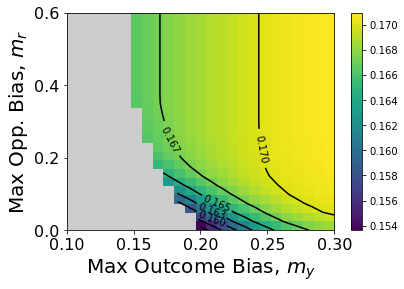

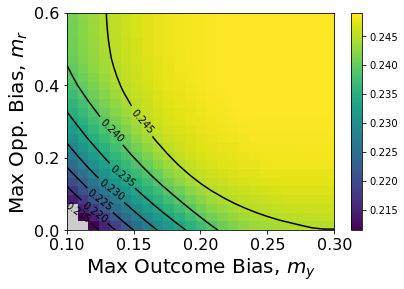

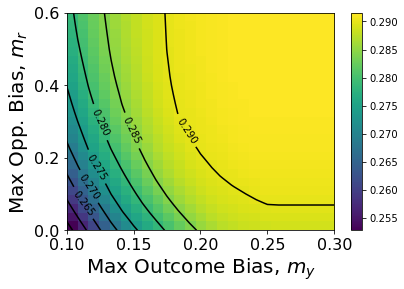

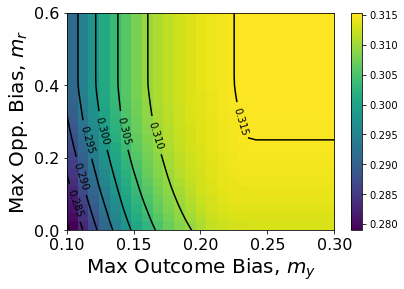

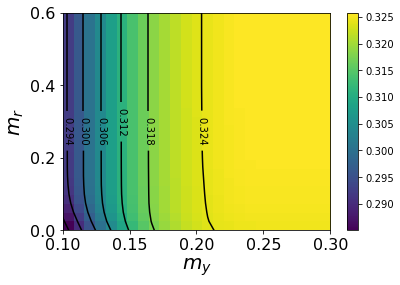

In [10]:
opt_list = np.array(opt_list).reshape((len(rmax_list), len(mr_list), len(my_list)))
dopt_list = np.array(dopt_list).reshape((len(rmax_list), len(mr_list), len(my_list)))
base_list = np.array(base_list).reshape((len(rmax_list), len(mr_list), len(my_list)))

current_cmap = plt.cm.get_cmap()
current_cmap.set_bad(color=(0.8,0.8,0.8))

docont = True
X, Y = np.meshgrid(my_list, mr_list)

idx = 0
if(docont): fig, ax = plt.subplots()
plt.imshow(opt_list[idx,::-1,:]-base_list[idx,::-1,:], extent=[0.10,0.30,0.0,0.6], aspect='auto') # vmin=0, vmax=0.65)
if(docont): 
    cs = ax.contour(X, Y, (opt_list[idx,:,:]-base_list[idx,:,:]), colors='k')
    ax.clabel(cs, inline=1, fontsize=10)

plt.xlabel("Max Outcome Bias, $m_y$", fontsize=20)
plt.ylabel("Max Opp. Bias, $m_r$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.colorbar()
plt.savefig("color_020.png", bbox_inches='tight', dpi=400)
plt.show()

idx = 1
if(docont): fig, ax = plt.subplots()
plt.imshow(opt_list[idx,::-1,:]-base_list[idx,::-1,:], extent=[0.10,0.30,0.0,0.6], aspect='auto') # vmin=0, vmax=0.65)
if(docont): 
    cs = ax.contour(X, Y, (opt_list[idx,:,:]-base_list[idx,:,:]), colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
plt.xlabel("Max Outcome Bias, $m_y$", fontsize=20)
plt.ylabel("Max Opp. Bias, $m_r$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.colorbar()
plt.savefig("color_040.png", bbox_inches='tight', dpi=400)
plt.show()

idx = 2
if(docont): fig, ax = plt.subplots()
plt.imshow(opt_list[idx,::-1,:]-base_list[idx,::-1,:], extent=[0.10,0.30,0.0,0.6], aspect='auto') # vmin=0, vmax=0.65)
if(docont): 
    cs = ax.contour(X, Y, (opt_list[idx,:,:]-base_list[idx,:,:]), colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
plt.xlabel("Max Outcome Bias, $m_y$", fontsize=20)
plt.ylabel("Max Opp. Bias, $m_r$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.colorbar()
plt.savefig("color_060.png", bbox_inches='tight', dpi=400)
plt.show()

idx = 3
if(docont): fig, ax = plt.subplots()
plt.imshow(opt_list[idx,::-1,:]-base_list[idx,::-1,:], extent=[0.10,0.30,0.0,0.6], aspect='auto') # vmin=0, vmax=0.65)
if(docont): 
    cs = ax.contour(X, Y, (opt_list[idx,:,:]-base_list[idx,:,:]), colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
plt.xlabel("Max Outcome Bias, $m_y$", fontsize=20)
plt.ylabel("Max Opp. Bias, $m_r$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.colorbar()
plt.savefig("color_080.png", bbox_inches='tight', dpi=400)
plt.show()

idx = 4
if(docont): fig, ax = plt.subplots()
plt.imshow(opt_list[idx,::-1,:]-base_list[idx,::-1,:], extent=[0.10,0.30,0.0,0.6], aspect='auto') # vmin=0, vmax=0.65)
if(docont): 
    cs = ax.contour(X, Y, (opt_list[idx,:,:]-base_list[idx,:,:]), colors='k')
    ax.clabel(cs, inline=1, fontsize=10)
plt.xlabel("$m_y$", fontsize=20)
plt.ylabel("$m_r$", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.colorbar()
plt.savefig("color_100.png", bbox_inches='tight', dpi=400)
plt.show()